In [1]:
!pip install -U keras

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"

import glob
import keras
import torch
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wandb.integration.keras3 import WandbMetricsLogger
from torch.utils.data import Dataset, DataLoader, Subset

In [2]:
feature_columns = [
    # 'LeftWristX', 'LeftWristY', 'LeftWristZ', 
    # 'LeftElbowX', 'LeftElbowY', 'LeftElbowZ', 
    # 'LeftShoulderX', 'LeftShoulderY', 'LeftShoulderZ', 
    'LeftElbowYaw', 'LeftElbowRoll', 'LeftShoulderRoll', 'LeftShoulderPitch',
    'origin_x', 'origin_y', 'origin_z',
    'goal_x', 'goal_y', 'goal_z',
    'is_grasped'
]
output_columns = [
    'LeftElbowYaw' , 'LeftElbowRoll', 'LeftShoulderRoll', 'LeftShoulderPitch'
]

data_folder = glob.glob(r"..\NaoPickAndPlaceData\*\processed_step_10.csv")
feature_shape = (10, len(feature_columns))  # (window, features)
label_shape = (1, 1)  # (window, features)

cache_base_dir = "NaoCache"

column_ranges = {
    'LeftElbowYaw': (-120, 120), 'LeftElbowRoll': (-90, 0),
    'RightElbowYaw': (-120, 120), 'RightElbowRoll': (0, 90),
    'LeftShoulderRoll': (-45, 90), 'LeftShoulderPitch': (-120, 120),
    'RightShoulderRoll': (-90, 45), 'RightShoulderPitch': (-120, 120),
    # 'LeftElbowYawCos': (-1, 1), 'LeftElbowRollCos': (-1, 1),
    # 'RightElbowYawCos': (-1, 1), 'RightElbowRollCos': (-1, 1),
    # 'LeftShoulderRollCos': (-1, 1), 'LeftShoulderPitchCos': (-1, 1),
    # 'RightShoulderRollCos': (-1, 1), 'RightShoulderPitchCos': (-1, 1),
    # 'LeftElbowYawSin': (-1, 1), 'LeftElbowRollSin': (-1, 1),
    # 'RightElbowYawSin': (-1, 1), 'RightElbowRollSin': (-1, 1),
    # 'LeftShoulderRollSin': (-1, 1), 'LeftShoulderPitchSin': (-1, 1),
    # 'RightShoulderRollSin': (-1, 1), 'RightShoulderPitchSin': (-1, 1),
    'LeftWristX': (-1, 1), 'LeftWristY': (-1, 1), 'LeftWristZ': (0, 3),
    'RightWristX': (-1, 1), 'RightWristY': (-1, 1), 'RightWristZ': (0, 3),
    'LeftElbowX': (-1, 1), 'LeftElbowY': (-1, 1), 'LeftElbowZ': (0, 3),
    'RightElbowX': (-1, 1), 'RightElbowY': (-1, 1), 'RightElbowZ': (0, 3),
    'LeftShoulderX': (-1, 1), 'LeftShoulderY': (-1, 1), 'LeftShoulderZ': (0, 3),
    'RightShoulderX': (-1, 1), 'RightShoulderY': (-1, 1), 'RightShoulderZ': (0, 3),
    'origin_x': (0, 640), 'origin_y': (0, 480), 'origin_z': (0, 7),
    'goal_x': (0, 640), 'goal_y': (0, 480), 'goal_z': (0, 7),
    # 'LeftWristX_PX': (0, 640), 'LeftWristY_PX': (0, 480),
    # 'RightWristX_PX': (0, 640), 'RightWristY_PX': (0, 480),
    # 'LeftElbowX_PX': (0, 640), 'LeftElbowY_PX': (0, 480),
    # 'RightElbowX_PX': (0, 640), 'RightElbowY_PX': (0, 480),
    # 'LeftShoulderX_PX': (0, 640), 'LeftShoulderY_PX': (0, 480),
    # 'RightShoulderX_PX': (0, 640), 'RightShoulderY_PX': (0, 480),
    # 'WristBallDistance': (0, 800), 'WristBoxDistance': (0, 800), 'BallBoxDistance': (0, 800)
}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def normalize_columns(df):
    for column, (min_val, max_val) in column_ranges.items():
        df[column] = (df[column] - min_val) / (max_val - min_val)
        if min_val < 0:
            df[column] = 2 * df[column] - 1
    return df


class CustomDataset(Dataset):
    def __init__(self, data_folder, feature_columns, output_columns, label_shape):
        self.data_folder = data_folder
        self.feature_columns = feature_columns
        self.output_columns = output_columns
        self.label_shape = label_shape
        self.data = list(self.generator())

    def generator(self):
        for file in self.data_folder:
            df = pd.read_csv(file)
            df = df.dropna()
            df = normalize_columns(df)

            selected_features = df[self.feature_columns].values.astype(np.float64)
            raw_data = df[self.output_columns].values.astype(np.float64)
            
            min_skip = 5
            for i in range(0, len(df) - 1):
                if i < feature_shape[0]:
                    features = selected_features[:i + 1]

                    num_rows, num_columns = features.shape
                    num_rows_to_add = feature_shape[0] - num_rows
                    new_rows_array = np.full((num_rows_to_add, num_columns), 0)
                    features = np.concatenate((new_rows_array, features), axis=0)
                else:
                    features = selected_features[i - feature_shape[0] + 1:i + 1]

                current_label = raw_data[i:i + self.label_shape[0]]
                for skip in range(min_skip, 100):
                    diff = 0 if i + skip < len(df) - 1 else -len(df) + i + skip + 2
                    next_label = raw_data[i + 1 + skip - diff:i + 1 + skip - diff + self.label_shape[0]]
                    # labels = next_label - current_label
                    labels = next_label
                    labels = labels.squeeze(0)
                    min_skip = skip
                    if abs((next_label - current_label)[0]).sum() > 0.2:
                        break
                        
                labels = torch.tensor(labels, dtype=torch.float64, device=device)
                
                yield torch.tensor(features, dtype=torch.float64, device=device), dict(zip(map(lambda x: f'output_{x}', self.output_columns), labels))
                yield torch.tensor(np.repeat(selected_features[i:i + 1], feature_shape[0], axis=0), dtype=torch.float64, device=device), dict(zip(map(lambda x: f'output_{x}', self.output_columns), labels))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)



def create_dataset(data_folder, output_columns, label_shape, cache_path=None):
    if cache_path and os.path.exists(cache_path):
        dataset = torch.load(cache_path)
    else:
        dataset = CustomDataset(data_folder, feature_columns, output_columns, label_shape)
        # if cache_path:
        #     torch.save(dataset, cache_path)

    return dataset

In [4]:
def split_dataset(dataset, train_size, batch_size):
    dataset_size = len(dataset)
    train_size = int(dataset_size * train_size)

    indices = list(range(dataset_size))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [5]:
def train_and_merge_models(data_folder, output_columns, feature_shape, label_shape, cache_base_dir, split_ratio=0.8, batch_size=4096):
    # wandb.init(project="GbN", entity="GbN")
    
    dataset = create_dataset(data_folder, output_columns, label_shape, cache_path=cache_base_dir)
    dataset_train, dataset_val = split_dataset(dataset, split_ratio, batch_size)

    # Create input layer (shared)
    initializer = keras.initializers.GlorotUniform(seed=42)
    input_layer = keras.layers.Input(shape=feature_shape)

    # Shared Backbone layers
    x = keras.layers.Dense(512, activation='relu', kernel_initializer=initializer,
                           kernel_regularizer=keras.regularizers.l2(0.01))(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Dense(512, activation='relu', kernel_initializer=initializer,
                           kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=False, kernel_initializer=initializer))(x)

    # Branch for each output
    outputs = []
    for i, output_column in enumerate(output_columns):
        branch = keras.layers.Dense(512, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=keras.regularizers.l2(0.01))(x)
        branch = keras.layers.BatchNormalization()(branch)
        branch = keras.layers.Dropout(0.3)(branch)

        branch = keras.layers.Dense(512, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=keras.regularizers.l2(0.01))(branch)
        branch = keras.layers.BatchNormalization()(branch)
        branch = keras.layers.Dropout(0.3)(branch)
        
        output_layer = keras.layers.Dense(label_shape[0], activation='linear', kernel_initializer=initializer,
                                          name=f'output_{output_column}')(branch)
        outputs.append({f'output_{output_column}': output_layer})

    # Create the model with multiple outputs
    model = keras.models.Model(inputs=input_layer, outputs=outputs)

    # Define loss and metrics for each output
    loss_dict = {f'output_{output_column}': 'mse' for output_column in output_columns}
    metrics_dict = {f'output_{output_column}': ['mae'] for output_column in output_columns}
    
    model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.1),
                  loss=loss_dict, metrics=metrics_dict
                  )

    # Print model summary
    model.summary()

    # Callbacks
    lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, min_lr=0.0000001)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)
    model_checkpoint = keras.callbacks.ModelCheckpoint(f"best_model_merged.keras", monitor='val_loss', verbose=1,
                                                       save_best_only=True, mode='min')

    # Train the model
    history = model.fit(dataset_train, validation_data=dataset_val, epochs=1000,
                        callbacks=[
                            lr_reducer, early_stop, model_checkpoint#, WandbMetricsLogger()
                        ])

    # Extract and log-transform the loss data
    epoch = np.arange(1, len(history.history[f'loss']) + 1)
    training_loss = np.log(history.history[f'loss'])
    validation_loss = np.log(history.history[f'val_loss'])

    # Create a plot for each output
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, training_loss, linestyle='-', color='b', label=f'Training Log Loss')
    plt.plot(epoch, validation_loss, linestyle='-', color='r', label=f'Validation Log Loss')

    # Add titles and labels
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Log Loss', fontsize=20)

    # Customize x-axis and y-axis tick label font size
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    # Add grid and legend
    plt.grid(True)
    plt.legend(fontsize=12)

    # Save the plot as a high-quality PDF file
    plt.savefig(f'validation_loss.pdf', format='pdf', bbox_inches='tight', dpi=300)

    # Show the plot (optional)
    plt.show()

    # Plot training and validation losses for each output
    for i, output_column in enumerate(output_columns):
        # Extract and log-transform the loss data
        epoch = np.arange(1, len(history.history[f'output_{output_column}_loss']) + 1)
        training_loss = np.log(history.history[f'output_{output_column}_loss'])
        validation_loss = np.log(history.history[f'val_output_{output_column}_loss'])

        # Create a plot for each output
        plt.figure(figsize=(10, 6))
        plt.plot(epoch, training_loss, linestyle='-', color='b', label=f'Training Log Loss {output_column}')
        plt.plot(epoch, validation_loss, linestyle='-', color='r', label=f'Validation Log Loss {output_column}')

        # Add titles and labels
        plt.xlabel('Epochs', fontsize=20)
        plt.ylabel('Log Loss', fontsize=20)

        # Customize x-axis and y-axis tick label font size
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)

        # Add grid and legend
        plt.grid(True)
        plt.legend(fontsize=12)

        # Save the plot as a high-quality PDF file
        plt.savefig(f'validation_loss_{output_column}.pdf', format='pdf', bbox_inches='tight', dpi=300)

        # Show the plot (optional)
        plt.show()
    # plt.plot(np.log(history.history[f'loss']), label=f'Training Log Loss')
    # plt.plot(np.log(history.history[f'val_loss']), label=f'Validation Log Loss')
    # plt.title(f'Training and Validation Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()
    # # Plot training and validation losses for each output
    # for i, output_column in enumerate(output_columns):
    #     plt.plot(np.log(history.history[f'output_{output_column}_loss']), label=f'Training Log Loss {output_column}')
    #     plt.plot(np.log(history.history[f'val_output_{output_column}_loss']), label=f'Validation Log Loss {output_column}')
    #     plt.title(f'Training and Validation Loss for {output_column}')
    #     plt.xlabel('Epochs')
    #     plt.ylabel('Loss')
    #     plt.legend()
    #     plt.show()
    
    return history

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 512)   │      6,144 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 512)   │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10, 512)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10, 512)   │    262,656 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 512)   │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 512)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1024)      │  4,198,400 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    524,800 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    524,800 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    524,800 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │    524,800 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    262,656 │ dropout_2[0][0] 

 Total params: 7,639,556 (29.14 MB)

 Trainable params: 7,629,316 (29.10 MB)

 Non-trainable params: 10,240 (40.00 KB)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 447.8498 - output_LeftElbowRoll_loss: 42.3359 - output_LeftElbowRoll_mae: 3.8464 - output_LeftElbowYaw_loss: 104.8987 - output_LeftElbowYaw_mae: 5.9229 - output_LeftShoulderPitch_loss: 37.6455 - output_LeftShoulderPitch_mae: 3.5497 - output_LeftShoulderRoll_loss: 68.7240 - output_LeftShoulderRoll_mae: 4.4165
Epoch 1: val_loss improved from inf to 41964096.00000, saving model to best_model_merged.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step - loss: 540.7162 - output_LeftElbowRoll_loss: 53.7162 - output_LeftElbowRoll_mae: 4.3335 - output_LeftElbowYaw_loss: 126.3659 - output_LeftElbowYaw_mae: 6.7296 - output_LeftShoulderPitch_loss: 47.7196 - output_LeftShoulderPitch_mae: 4.0165 - output_LeftShoulderRoll_loss: 88.7763 - output_LeftShoulderRoll_mae: 5.1390 - val_loss: 41964096.0000 - val_output_LeftElbowRoll_loss: 29418396.0000 - val_output_LeftElbowRoll_mae: 5164.9473 - val_output_LeftElbowYaw_loss: 2948326.0000 - val_output_LeftE

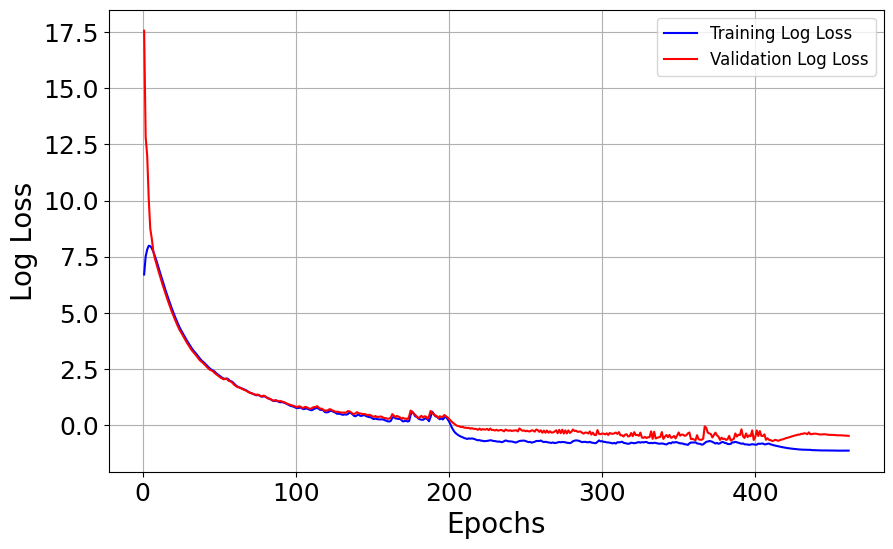

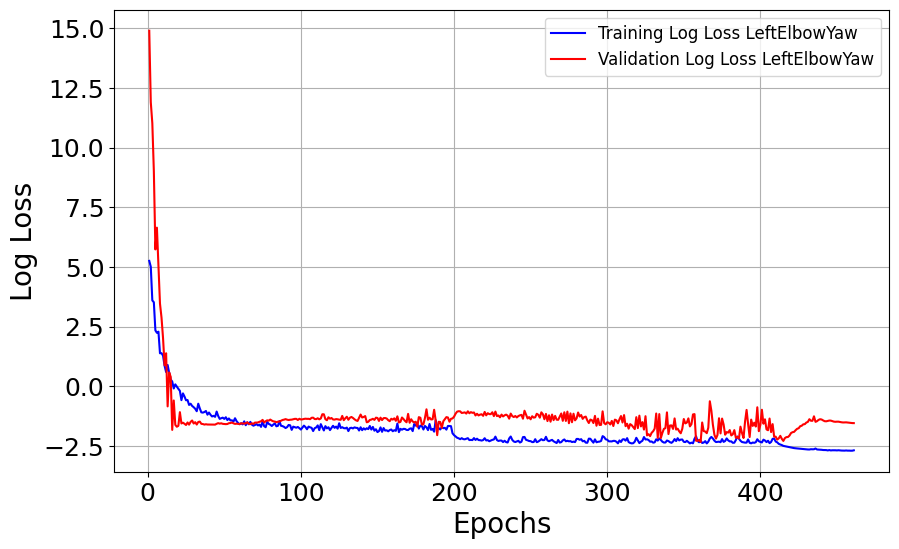

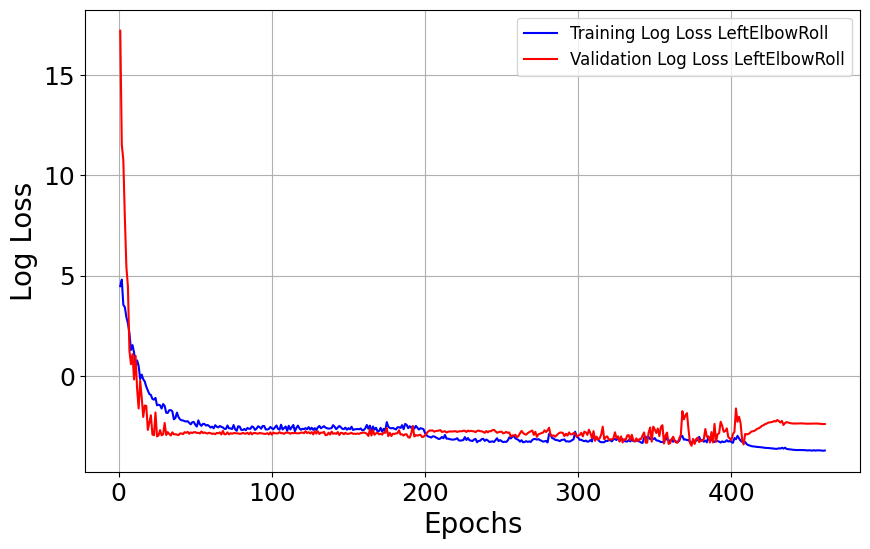

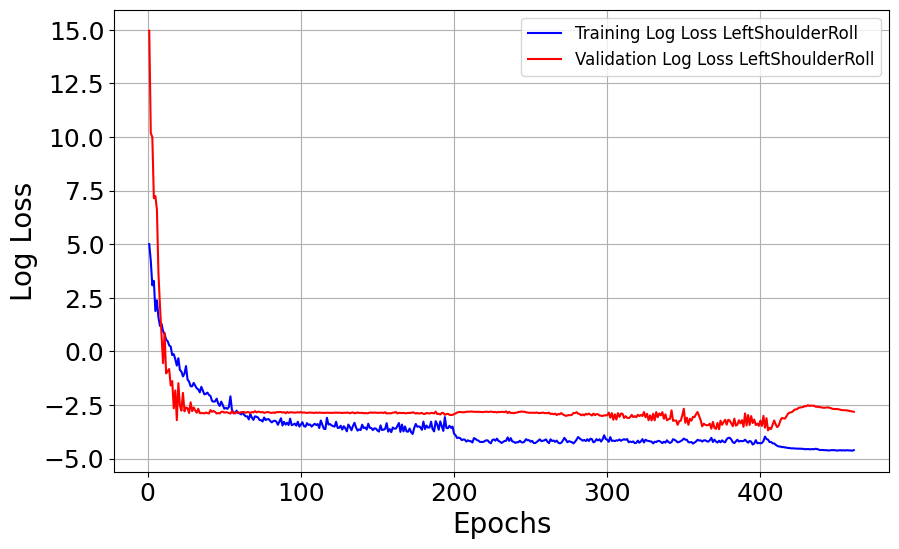

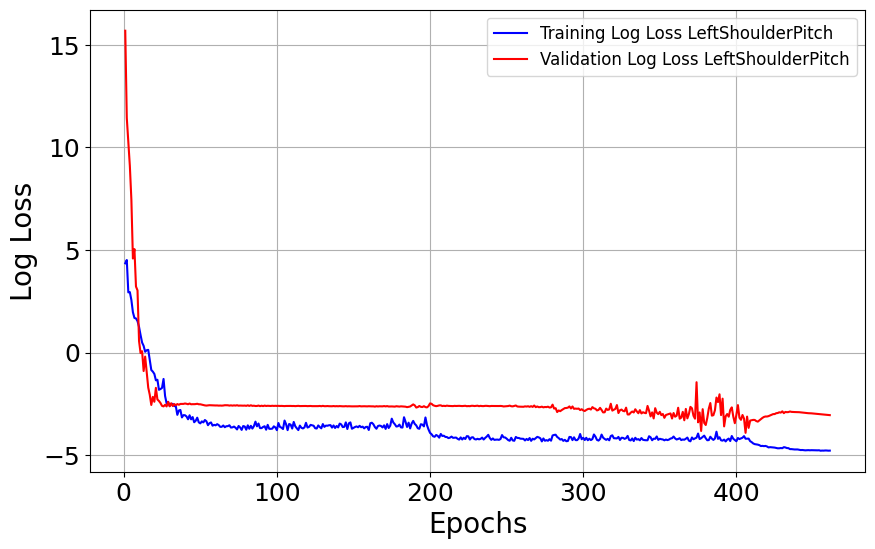

In [6]:
history = train_and_merge_models(data_folder, output_columns, feature_shape, label_shape, cache_base_dir)

In [7]:
def restore_scale(predictions, label_ranges):
    restored_predictions = []
    for i, label in enumerate(label_ranges.keys()):
        min_val, max_val = label_ranges[label]
        normalized_value = predictions[0]

        if min_val < 0:
            original_value = ((normalized_value + 1) / 2) * (max_val - min_val) + min_val
        else:
            original_value = normalized_value * (max_val - min_val) + min_val

        restored_predictions.append(original_value)
    return np.array(restored_predictions)
    
def calculate_prediction(dataset, model, label_ranges):
    all_predictions = {label: [] for label in label_ranges.keys()}
    all_actuals = {label: [] for label in label_ranges.keys()}

    for batch_data in dataset:
        features = batch_data[0]
        output_label = 'output_' + list(label_ranges.keys())[0]
        labels = batch_data[1][output_label].cpu().detach().numpy()

        predictions = np.array([p.cpu().detach().numpy() for p in model(features)[output_columns.index(output_label[7:])][output_label]])
        for i in range(len(features)):
            restored_predictions = restore_scale(predictions[i], label_ranges)
            actual_labels = [labels[i]]
            restored_actual_labels = restore_scale(actual_labels, label_ranges)

            for j, label in enumerate(label_ranges.keys()):
                all_predictions[label].append(restored_predictions[j])
                all_actuals[label].append(restored_actual_labels[j])
    
    return all_predictions, all_actuals

def plot_predictions(predications, actuals):
    for label, predication_list in predications.items():
        plt.figure()
        plt.plot(predication_list, label='Predication')
        plt.title(f'Predication for {label}')
        plt.xlabel('Data Point Index')
        plt.ylabel('Predication')
        plt.legend()
        plt.show()
    for label, actual_list in actuals.items():
        plt.figure()
        plt.plot(actual_list, label='Predication')
        plt.title(f'Actual for {label}')
        plt.xlabel('Data Point Index')
        plt.ylabel('Predication')
        plt.legend()
        plt.show()

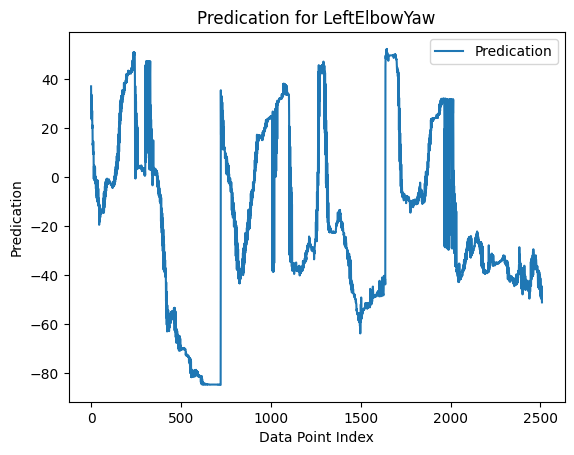

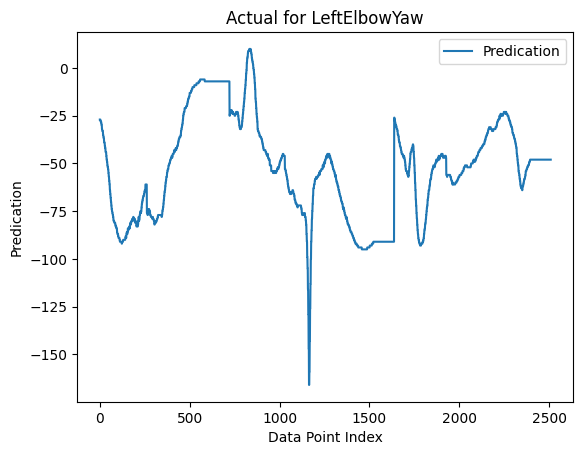

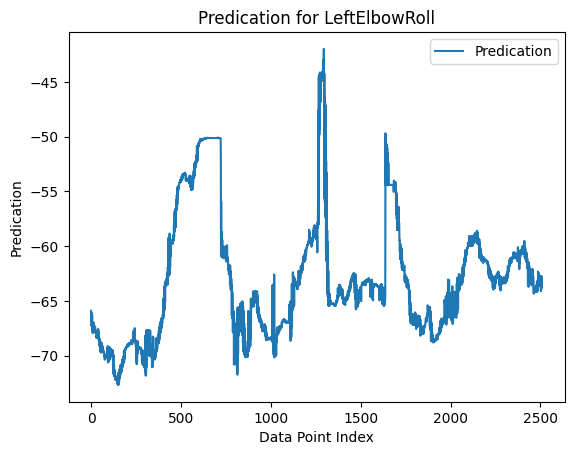

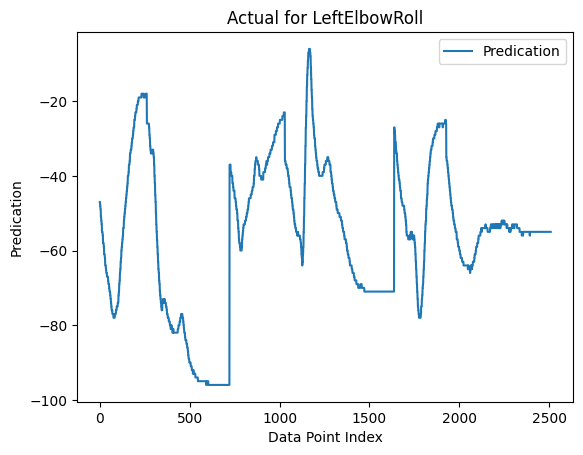

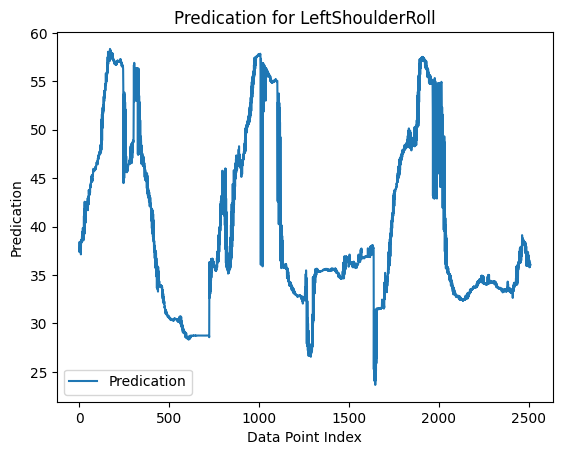

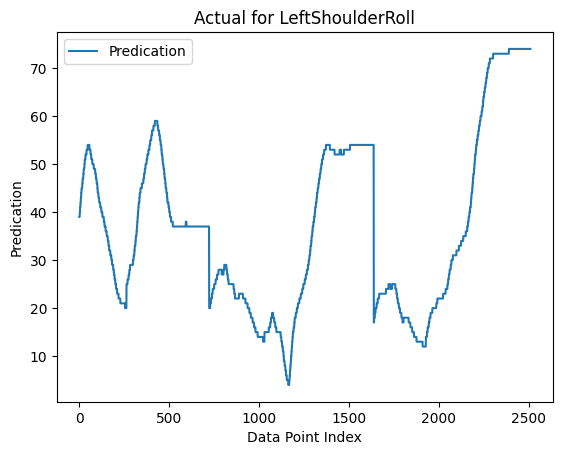

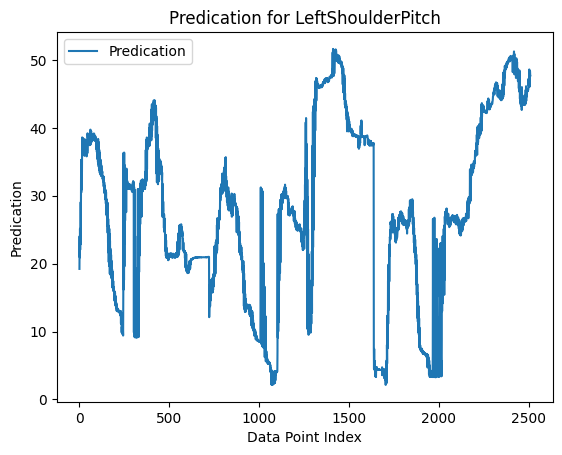

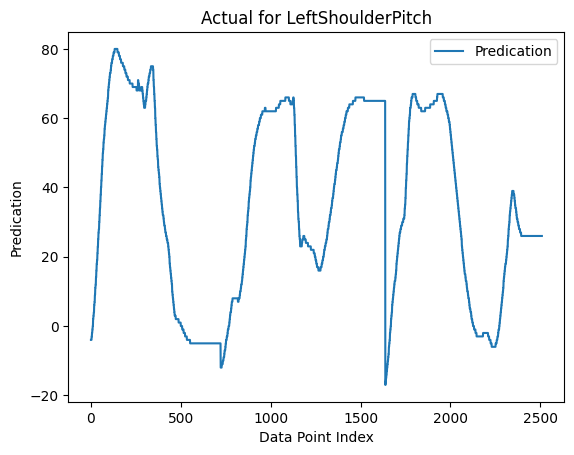

In [8]:
dataset = create_dataset(data_folder, output_columns, label_shape, cache_path=cache_base_dir)
dataset_train, dataset_val = split_dataset(dataset, 0.8, 1024)
for output_column in output_columns:
    model = keras.models.load_model(f"best_model_merged.keras")
    label_ranges = {column: column_ranges[column] for column in [output_column] if column in column_ranges}
    predications, actuals = calculate_prediction(dataset_val, model, label_ranges)
    plot_predictions(predications, actuals)